# <p style="text-align: center;">EE 380L: Data Mining</p>
# <p style="text-align: center;">Assignment 5</p>
## <p style="text-align: center;">Total points: 95   </p>
## <p style="text-align: center;">Due: November 24th (11/24/2020) submitted via Canvas by 11:59 pm</p>

Your homework should be written in a **Jupyter notebook**. You may work in groups of two if you wish. Only one student per team needs to submit the assignment on Canvas. But be sure to include name and UT eID for both students. 

Also, please make sure your code runs and the graphics (and anything else) are displayed in your notebook before submitting. (%matplotlib inline)* For the descriptive questions, you can write down the solution in paper and embed a picture of it to the notebook or type it out.

### Additional instructions : 
* In order to embed the image into notebook, convert the cell to Markdown and drag-drop the image, you should be able to view them before you submit.

* Make sure to submit the notebook with filename as your eID 

### Name(s)
1. Nishamathi Kumaraswamy (NK3528)
2. David Villareal (DLV554)

# Question 1 : Bayesian Belief Networks (15 pts)

![Question 1](https://i.imgur.com/3ayVbFi.jpeg) 

All nodes are binary and can take 0/1 values

The probabilities are given below:

P(Bark = 1) = 0.05   
P(Rain = 1) = 0.01


P(Scared = 1 | Bark = 0, Rain = 0) = 0.001  
P(Scared = 1 | Bark = 0, Rain = 1) = 0.1  
P(Scared = 1 | Bark = 1, Rain = 0) = 0.8  
P(Scared = 1 | Bark = 1, Rain = 1) = 0.9  

P(Hides = 1 | Scared = 1) = 0.95  
P(Hides = 1 | Scared = 0) = 0.05  

For the given Bayesian network, Compute the following probabilities :  


**(a) (4 pts)** Find the probability that cat hides = 1.  
**(b) (4 pts)** Given that cat got scared (Scared = 1), what is the probability that it rained (Rain = 1)?  
**(c) (7 pts)** Given that cat got scared (Scared = 1) and the dog barked (Bark = 1), what is the probability that it rained (Rain = 1)?

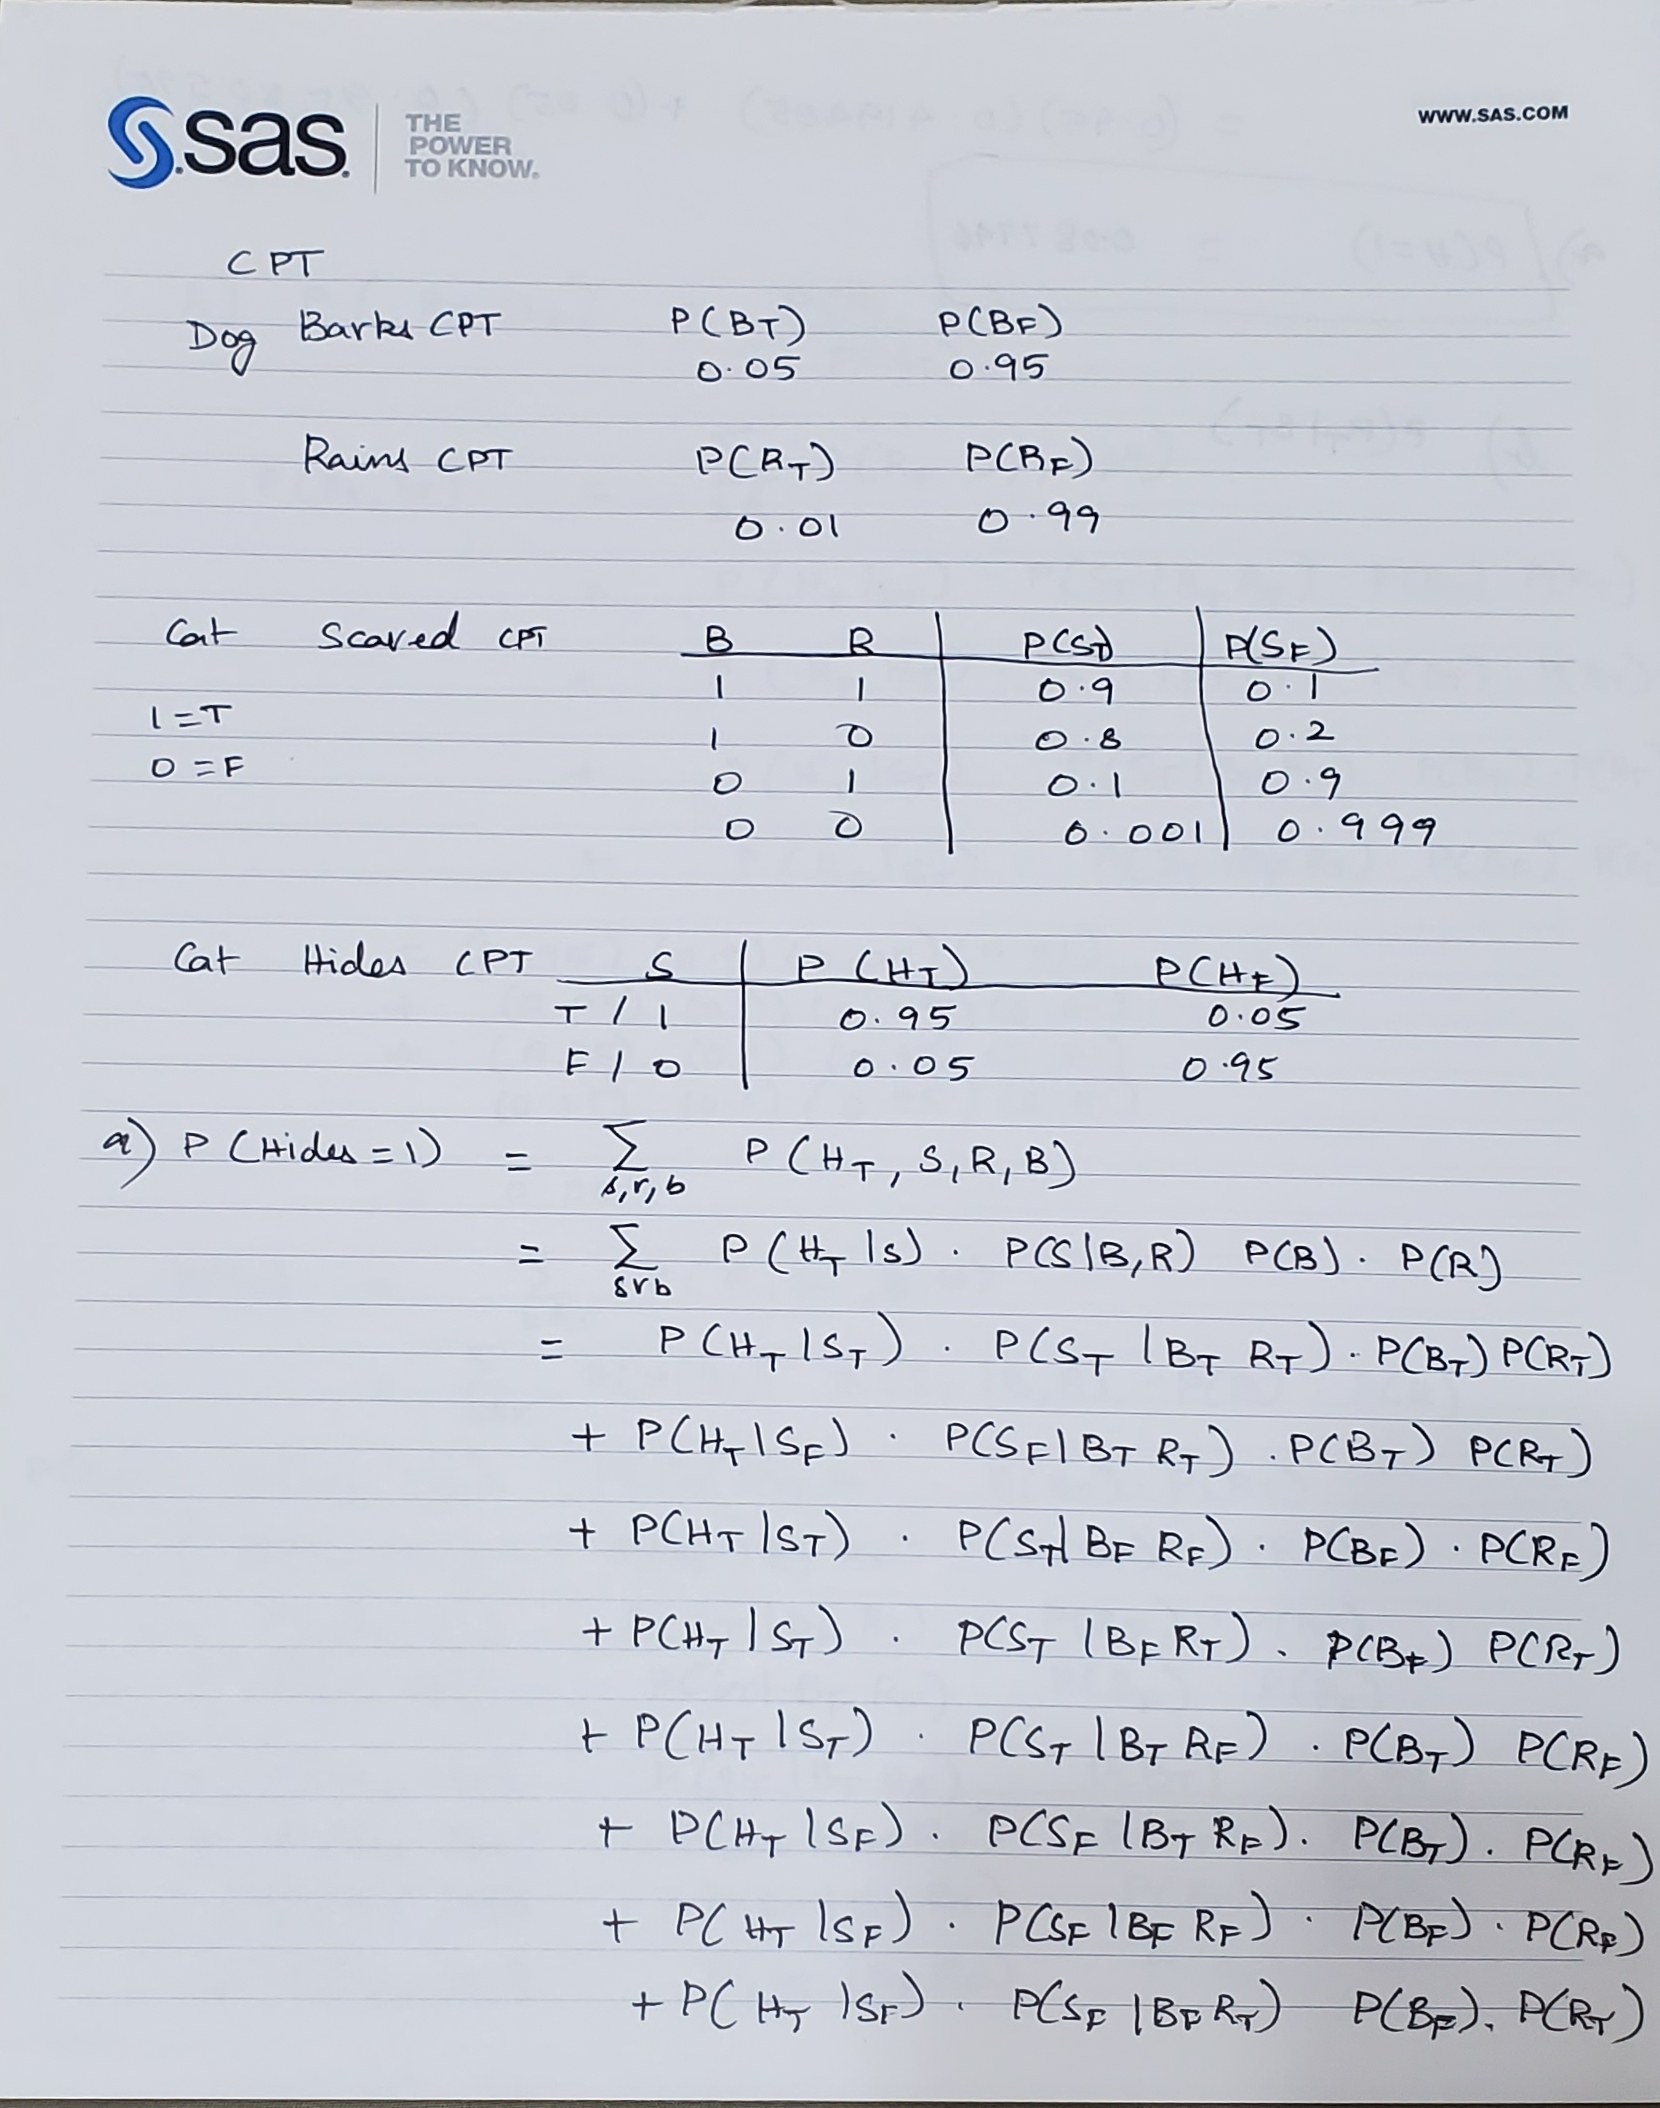

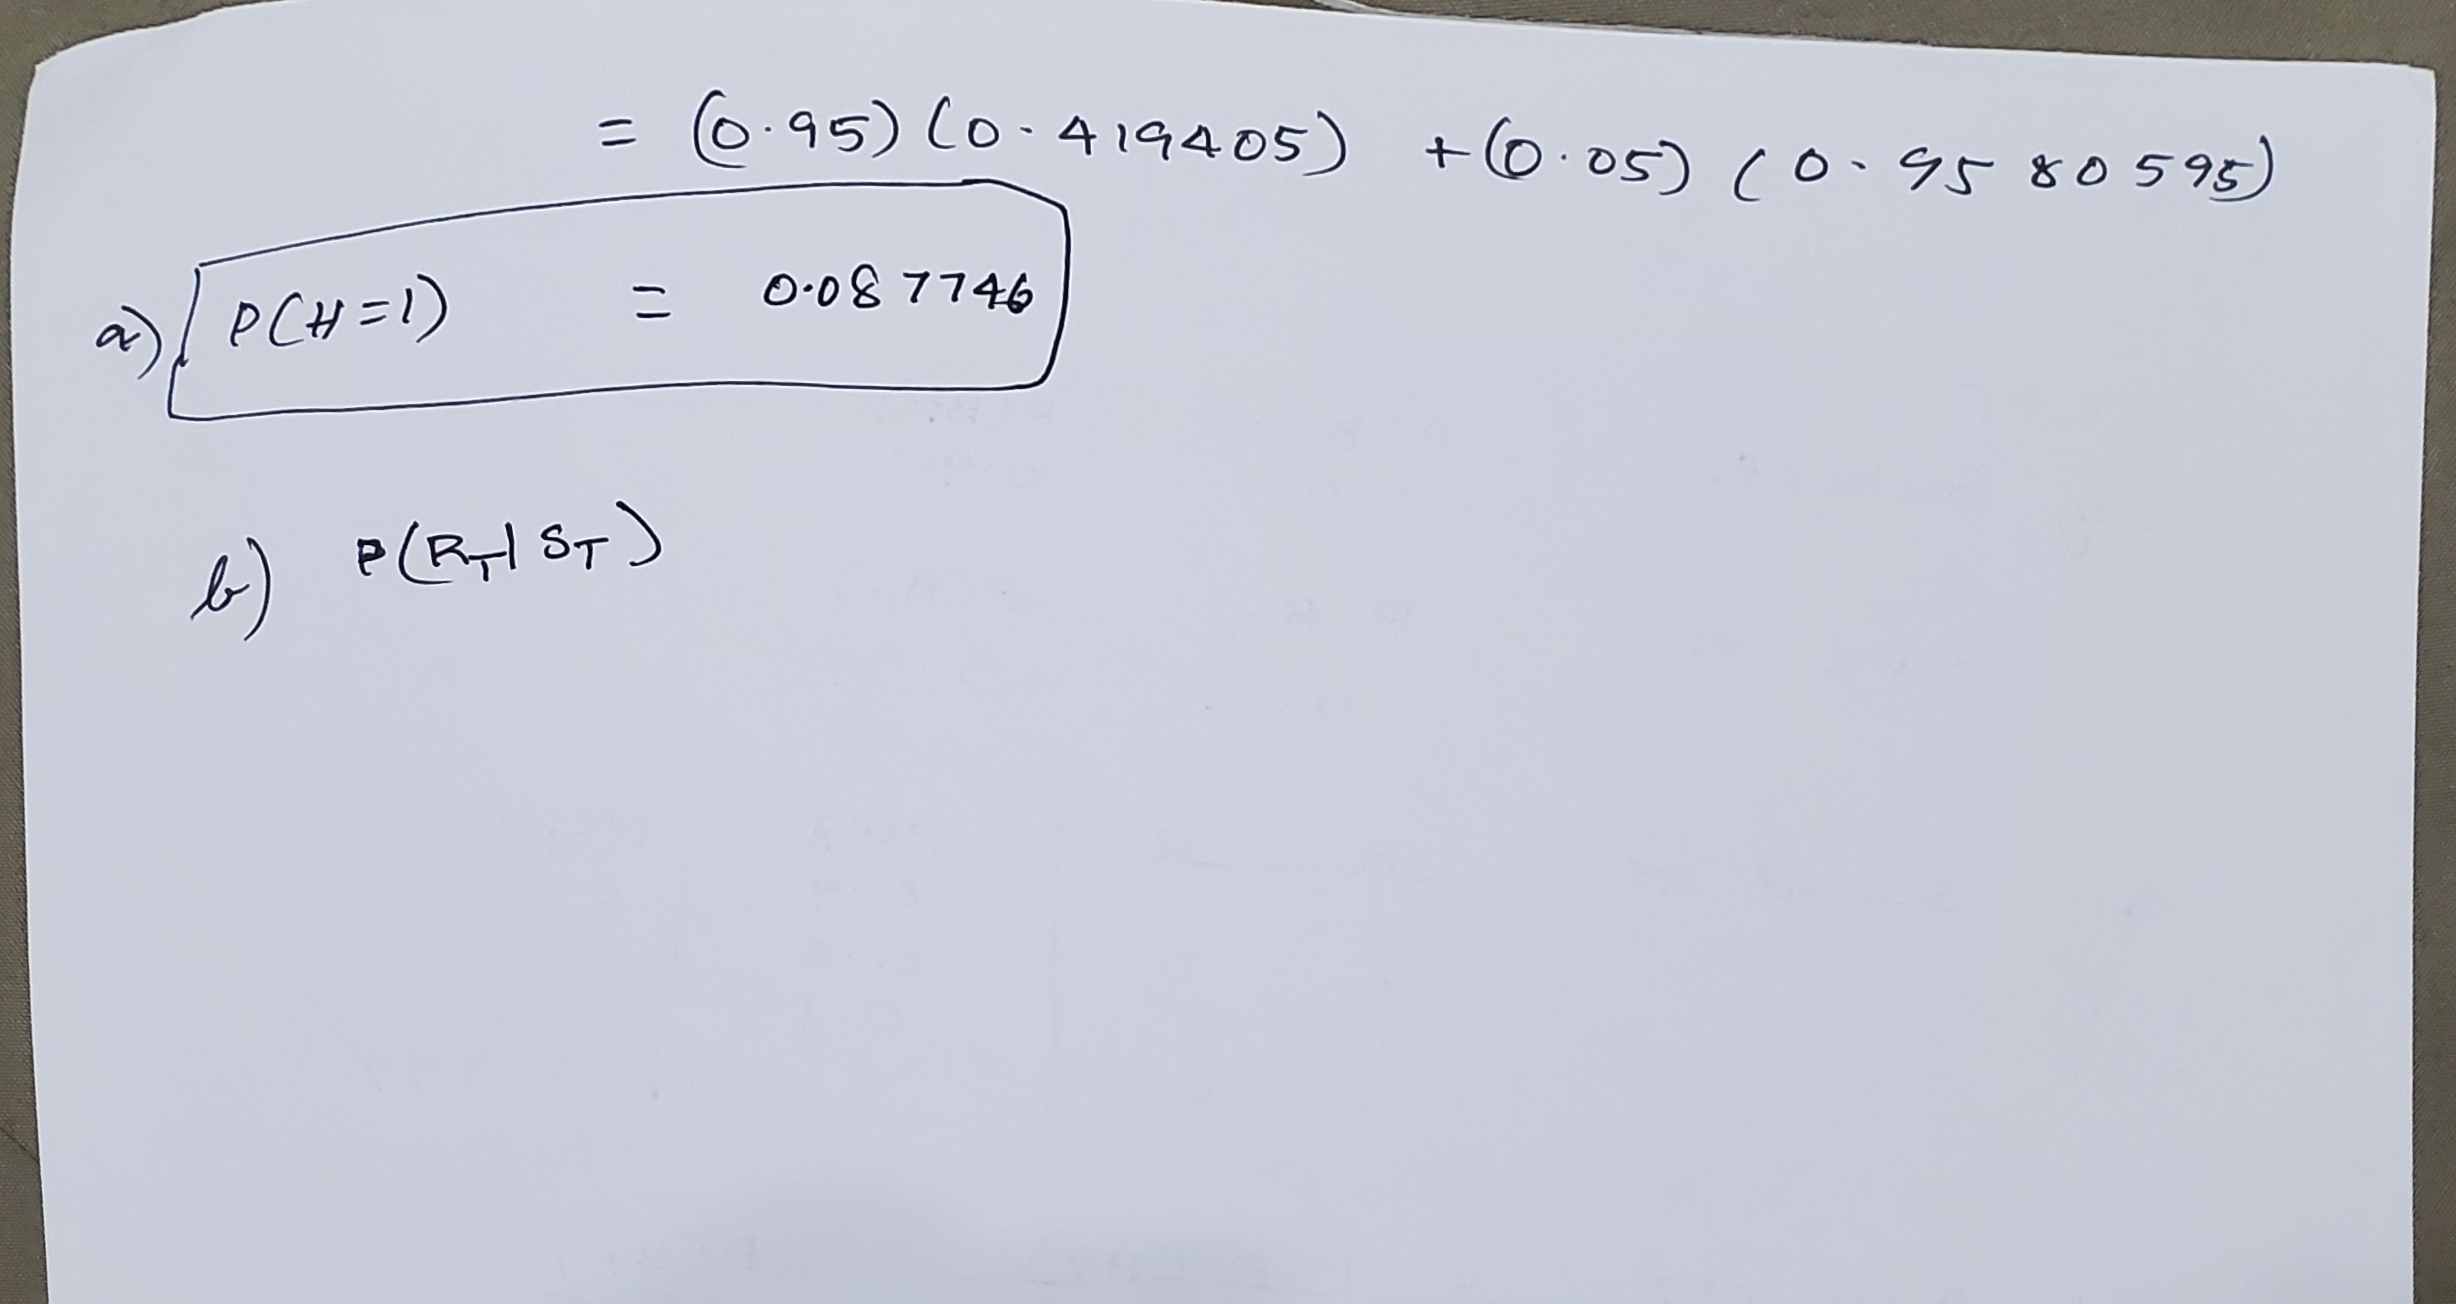
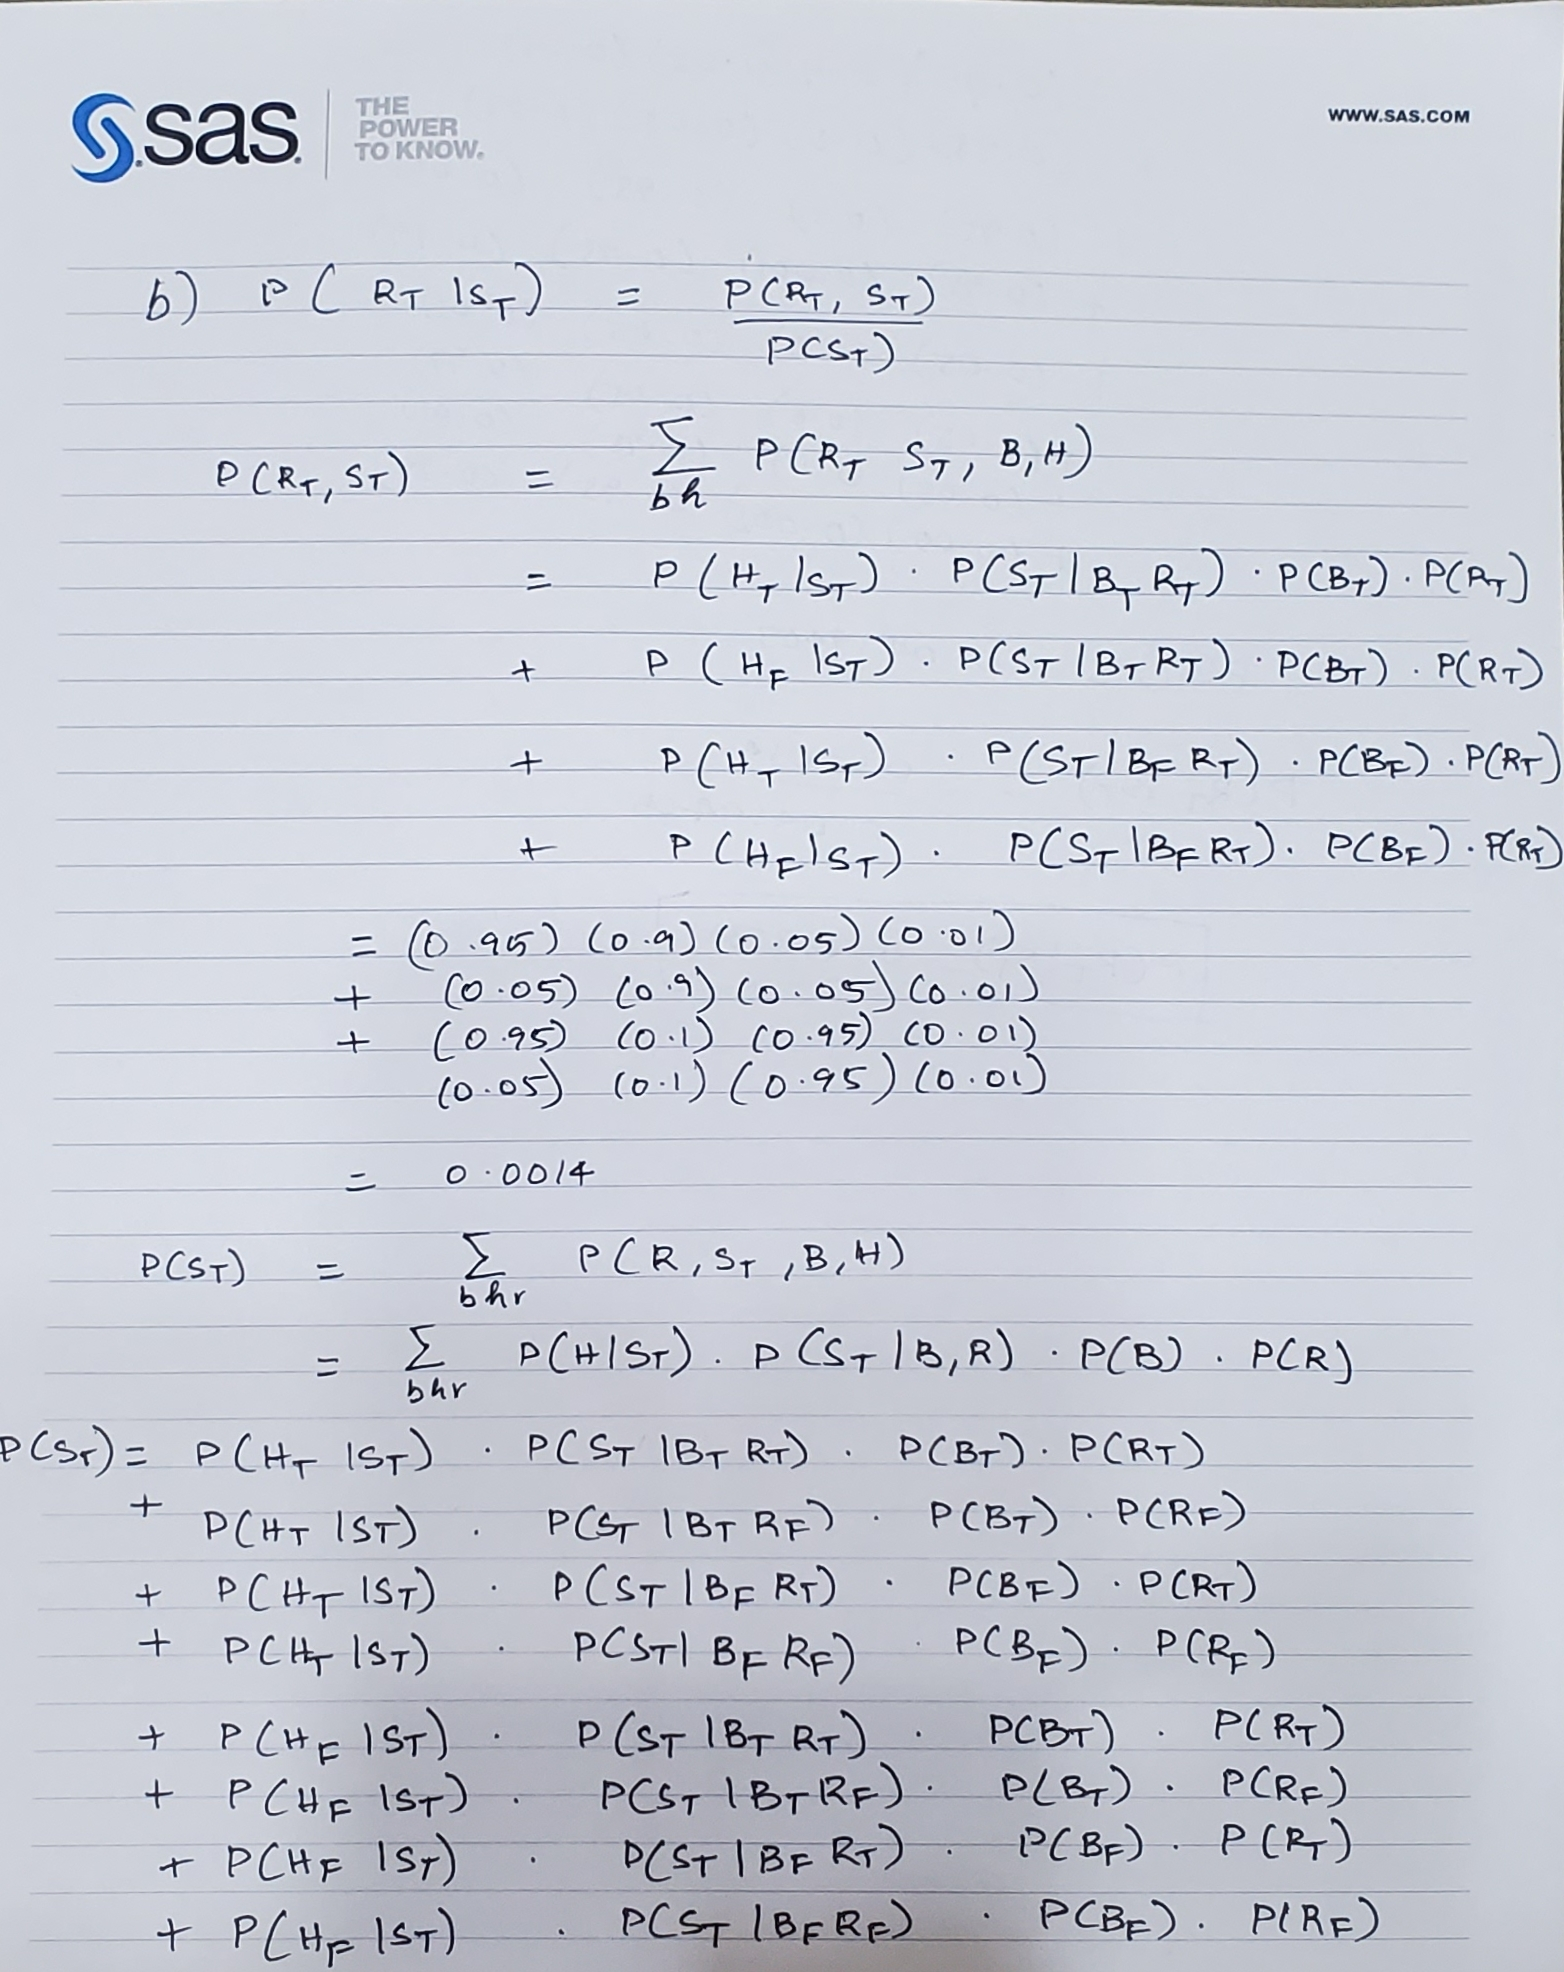
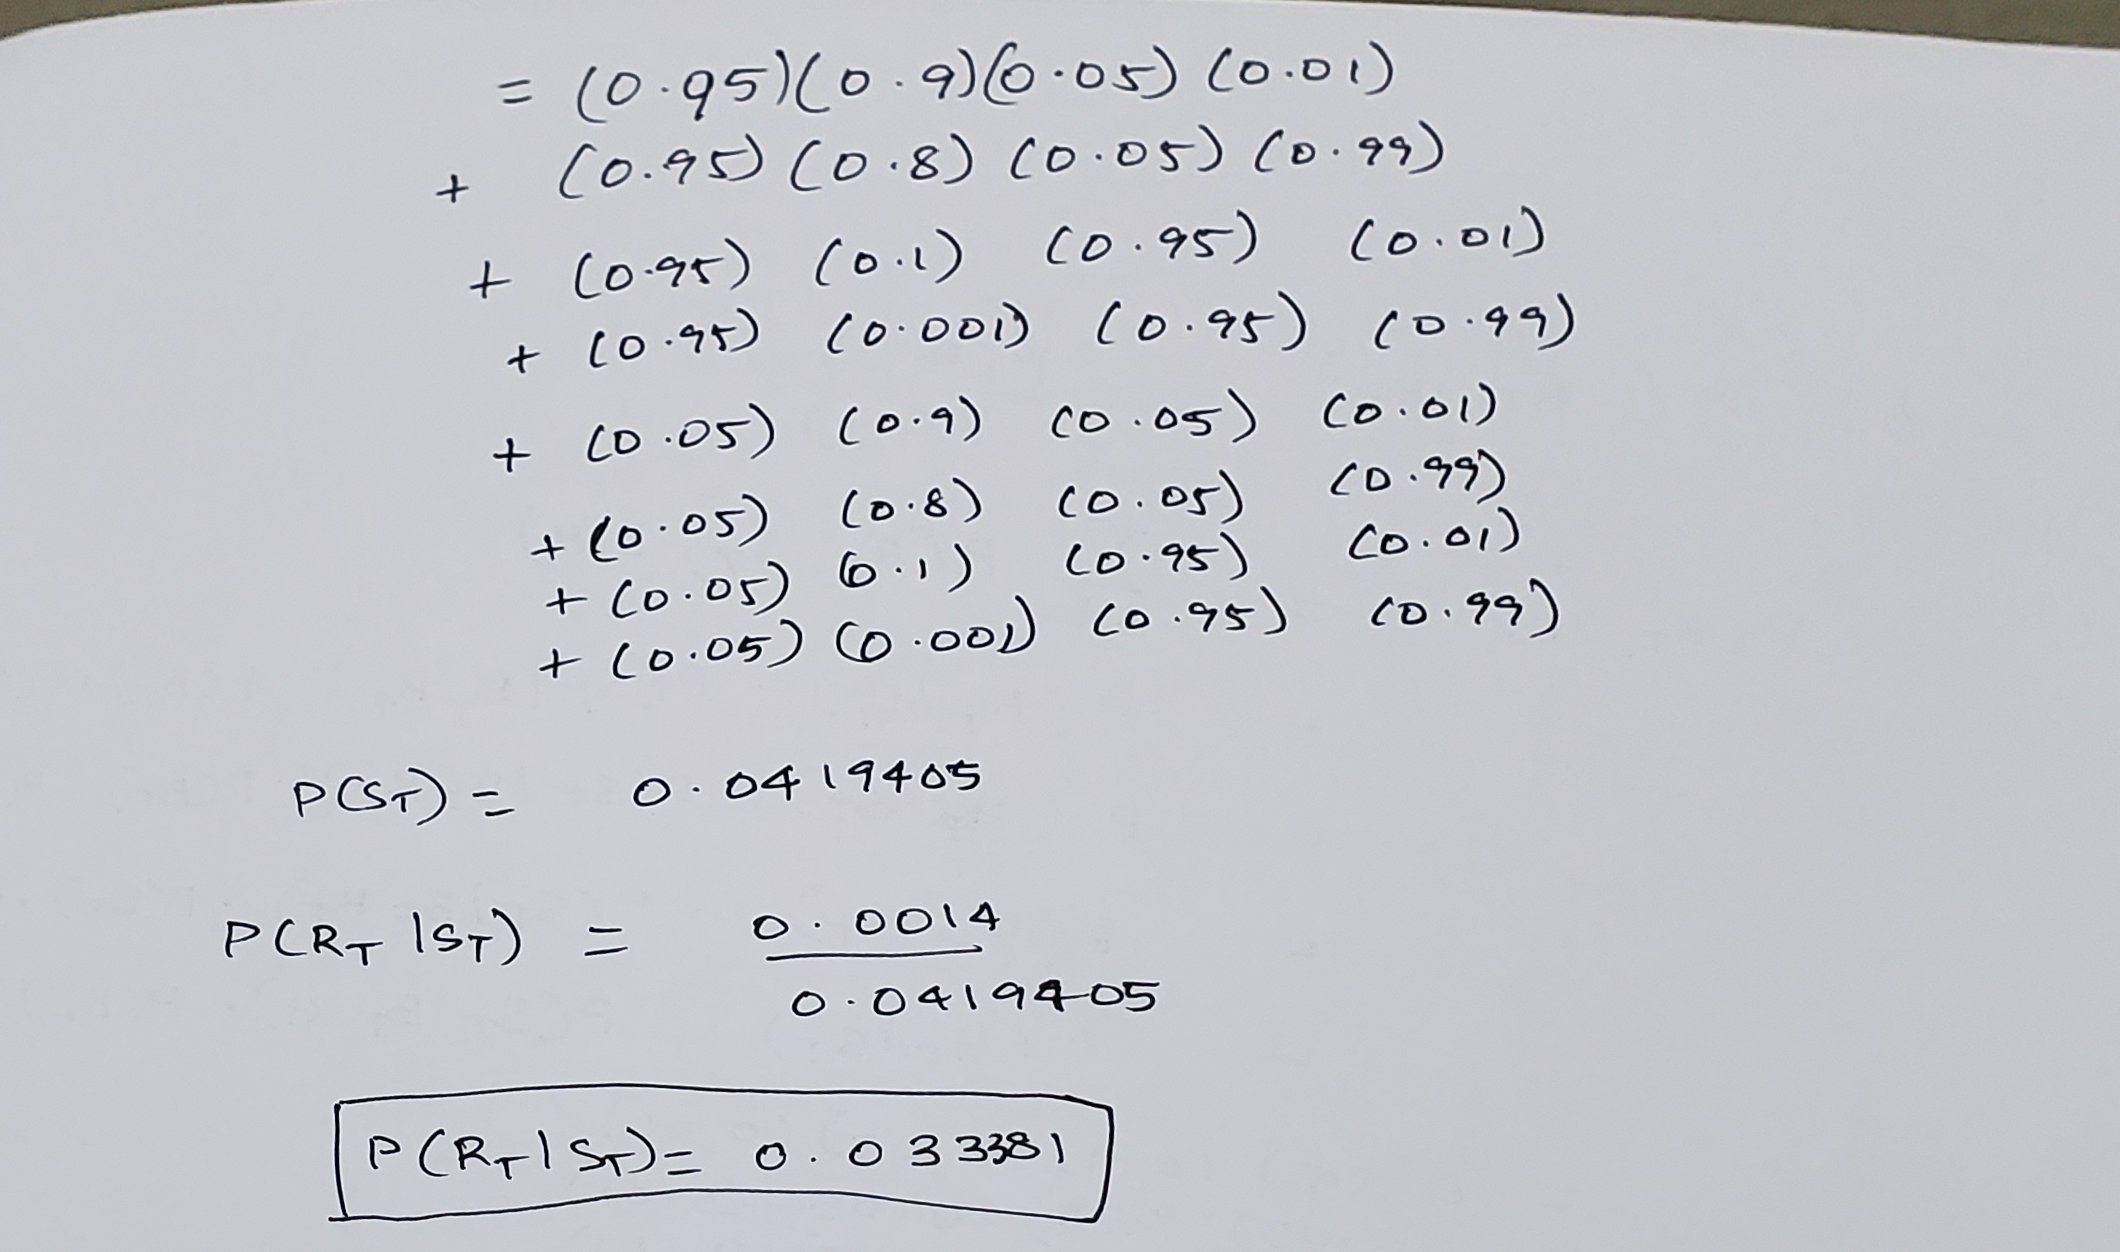
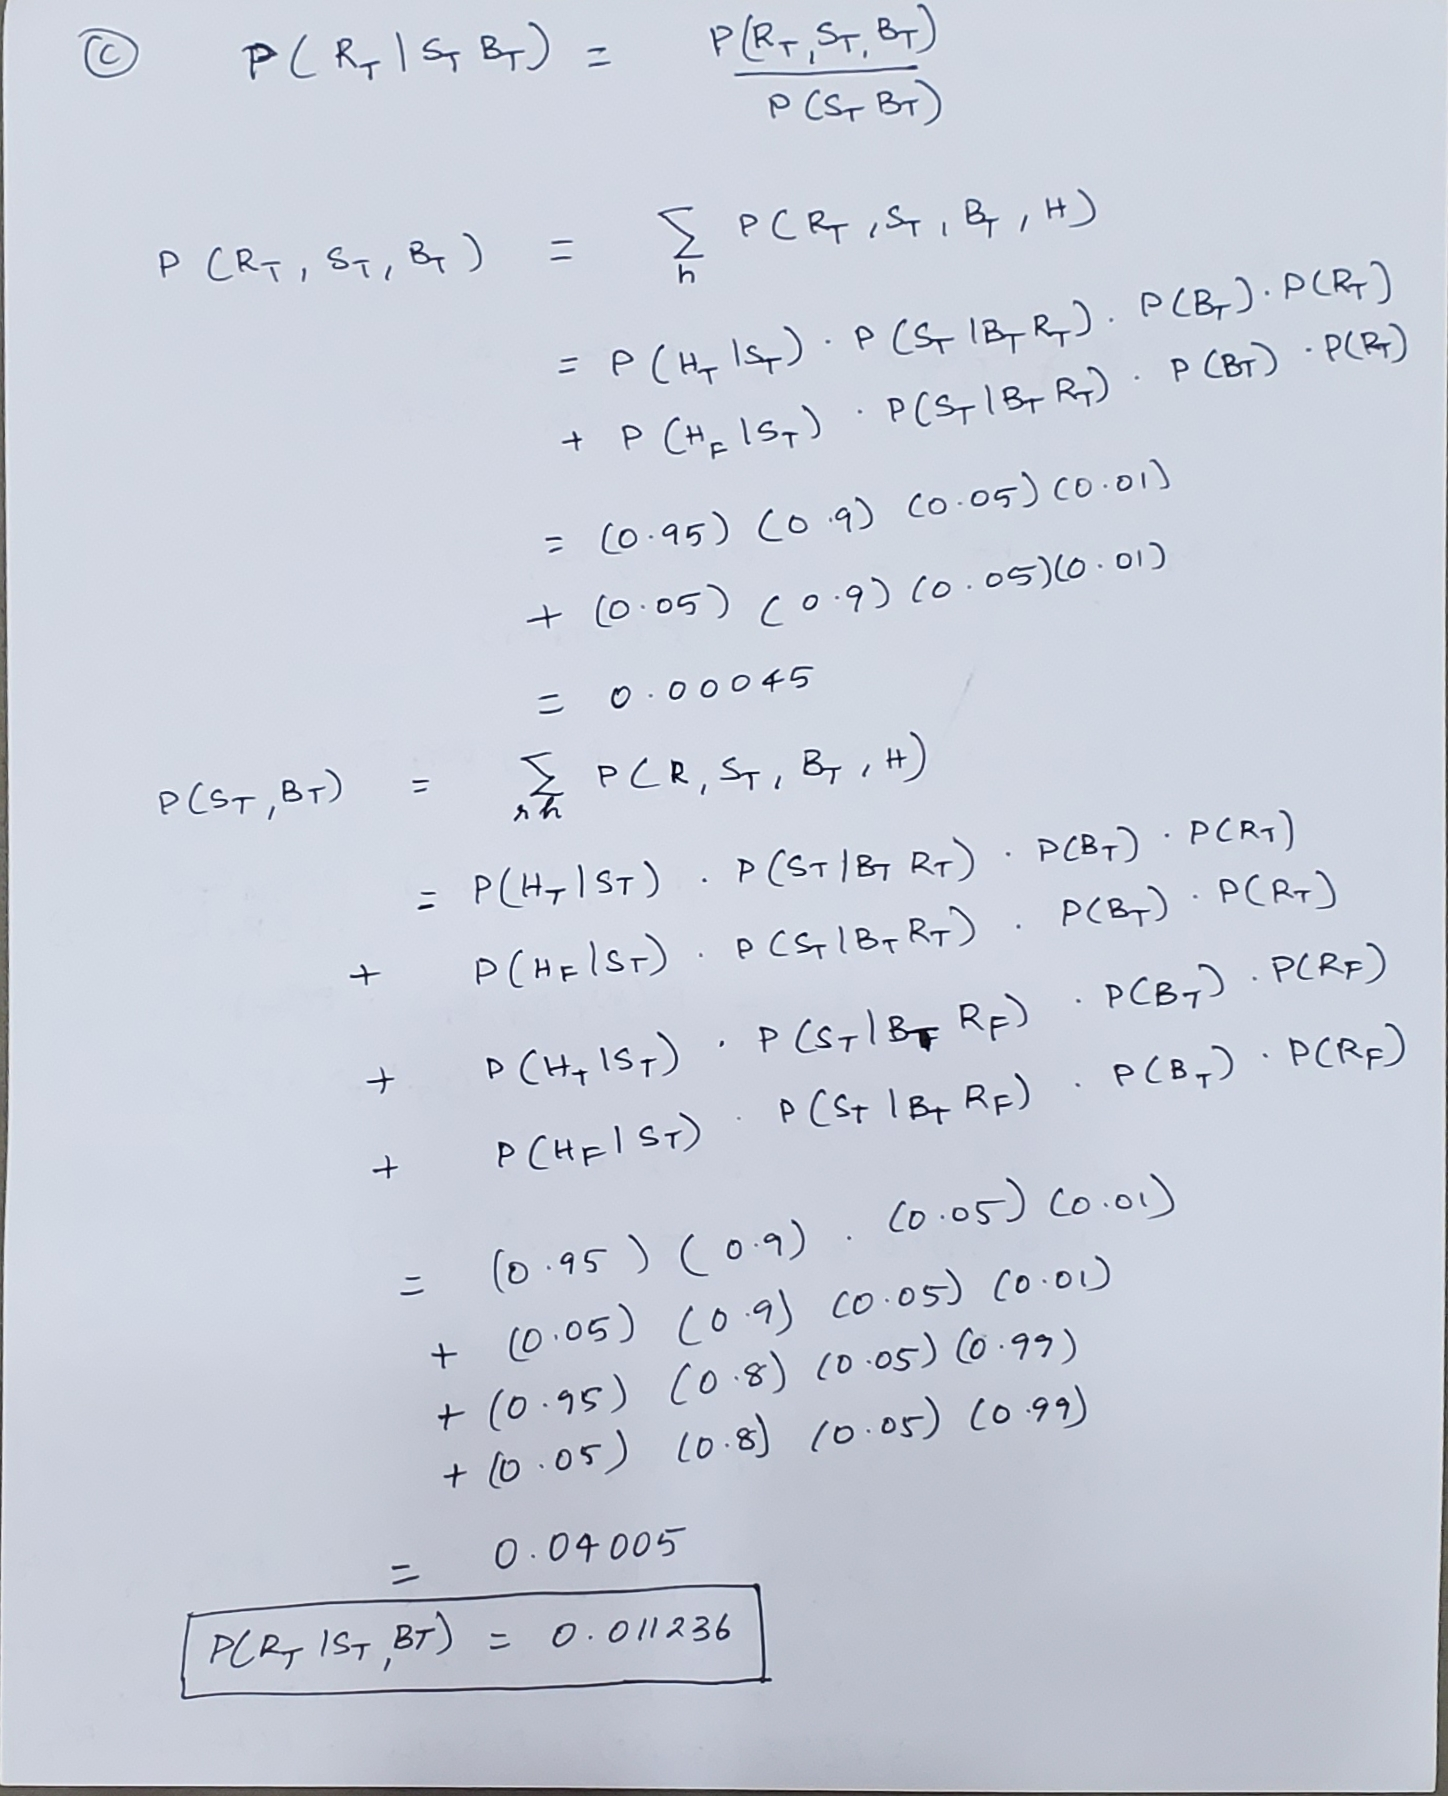

# Question 2 - **Random Forest (30 pts)**  

The goal of this problem is to explore the effect of feature selection using  the following dataset (same as in HW 4) https://www.kaggle.com/wendykan/lending-club-loan-data

Since the dataset is really huge, we will use only a certain set of features and samples to build our model. We will also use only two classes instead of all.

The modified dataset with reduced number of samples has been prepared for your use. The file can be downloaded using the code below. You can also find it [here](https://drive.google.com/file/d/1Gv_N1rHLqDizxUck6l06BfniR30Pw0Zs/view?usp=sharing) in case you have a different environment and this code does not run.



%%bash
ggID='1Gv_N1rHLqDizxUck6l06BfniR30Pw0Zs'  
ggURL='https://drive.google.com/uc?export=download'  
filename="$(curl -sc /tmp/gcokie "${ggURL}&id=${ggID}" | grep -o '="uc-name.*</span>' | sed 's/.*">//;s/<.a> .*//')"  
getcode="$(awk '/_warning_/ {print $NF}' /tmp/gcokie)"  

if [ -e "${filename}" ]; then
    echo 'File already exists'
else
    curl -Lb /tmp/gcokie "${ggURL}&confirm=${getcode}&id=${ggID}" -o "${filename}"  
fi

In [1]:
import os, sys, re
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
#Block warnings to provide more presentable notebook 
#%%#
import warnings
warnings.filterwarnings('ignore')

# Point to appropriate HW directory
#s.chdir("C:/Users/Acer/Desktop/Nisha/Nisha Career/PhD/Coursework/Fall 2020/Homework Assignments/HW4")

dataset = pd.read_csv('loan.csv')
df = dataset.fillna(0)

def LoanResult(status):
    if (status == 'Fully Paid') or (status == 'Current'):
        return 1
    else:
        return 0

df['loan_status'] = df['loan_status'].apply(LoanResult)

df = df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
             'emp_length', 'home_ownership','annual_inc', 'verification_status', 'loan_status',
             'purpose','addr_state', 'dti','open_acc', 'pub_rec', 'revol_bal', 'revol_util', 
             'initial_list_status', 'recoveries','collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
             'application_type', 'tot_coll_amt', 'tot_cur_bal', 'avg_cur_bal', 'chargeoff_within_12_mths',
             'pub_rec_bankruptcies', 'tax_liens', 'debt_settlement_flag']]
df_cat = df.select_dtypes(exclude=['int64', 'float64'])
df = pd.get_dummies(df, df_cat.columns.values)
df.head()


loan_amnt  funded_amnt  funded_amnt_inv  int_rate  installment  annual_inc  \
0       2500         2500           2500.0     13.56        84.92     55000.0   
1      30000        30000          30000.0     18.94       777.23     90000.0   
2       5000         5000           5000.0     17.97       180.69     59280.0   
3       4000         4000           4000.0     18.94       146.51     92000.0   
4      30000        30000          30000.0     16.14       731.78     57250.0   

   loan_status    dti  open_acc  pub_rec  ...  last_pymnt_d_Feb-2019  \
0            1  18.24       9.0      1.0  ...                      1   
1            1  26.52      13.0      1.0  ...                      1   
2            1  10.51       8.0      0.0  ...                      1   
3            1  16.74      10.0      0.0  ...                      1   
4            1  26.35      12.0      0.0  ...                      1   

   last_pymnt_d_Jan-2019  last_pymnt_d_Jul-2018  last_pymnt_d_Nov-2018  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   
3                      0                      0                      0   
4                      0                      0                      0   

   last_pymnt_d_Oct-2018  last_pymnt_d_Sep-2018  application_type_Individual  \
0                      0                      0                            1   
1                      0                      0                            1   
2                      0                      0                            1   
3                      0                      0                            1   
4                      0                      0                            1   

   application_type_Joint App  debt_settlement_flag_N  debt_settlement_flag_Y  
0                           0                       1                       0  
1                           0                       1                       0  
2                           0                       1                       0  
3                           0                       1                       0  
4                           0                       1                       0  

[5 rows x 161 columns]

Select the `loan_status` column as the target column.  


**Part 1: (3 pts)** Split the dataset into train and test set with 25% data in test set and random_state = 42. Perform [Min-Max Scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) on the dataset. Print the total number of features. 

**Part 2: (5 pts)** Use the dataset to create a `RandomForestClassifier(n_estimators=5, random_state=42)` model and print the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) to show the precision, recall and F1 score based on the test set.  

**Part 3: (6 pts)** Use [$\chi^2$](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) test to select the top 100, 30 and 10 features using [SelectKBest](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) module. Train a random forest model and print the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) for each of the trained models.  

**Note:** $\chi^2$ test requires non-negative values only for all features. Since we have performed Min-Max scaling previously (where the default behavior is to scale features between 0 and 1, there should not be any problem performing this test.)   

**Part 4: (6 pts)** [Plot the ROC curves](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/21_plot_roc_curve.ipynb) for all of the 4 models.  

**Part 5: (8 pts)** Plot the feature importance for each of the 4 random forest models that you have trained to show the top 5 features. ([Get feature names after feature selection](https://stackoverflow.com/a/43765224), [Plot feature importance using Pandas and matplotlib](https://stackoverflow.com/a/51520906))  

**Part 6: (2 pts)** What do you observe from the ROC curves?

# Solution

**Part 1: (3 pts)** 

In [2]:
df.shape
# Prepare the dataset
y=df['loan_status'] 
X=df.drop('loan_status',1) #Target column

In [3]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=42)

In [4]:
from sklearn.preprocessing import MinMaxScaler
# Min-Max scaling
scaler = MinMaxScaler()
X_train_scld=scaler.fit_transform(X_train)#Fit transform min-max scaler to train data
X_test_scld=scaler.transform(X_test) # transform test data based on train data fit by min max scaler
print('Total number of features in X are :', X.shape[1])

Total number of features in X are : 160


**Part 2: (5 pts)** Use the dataset to create a `RandomForestClassifier(n_estimators=5, random_state=42)` model and print the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) to show the precision, recall and F1 score based on the test set.  

In [5]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=5, random_state=42)
rfc.fit(X_train_scld, y_train)

RandomForestClassifier(n_estimators=5, random_state=42)

In [6]:
rfc_pred = rfc.predict(X_test_scld)

In [7]:
from sklearn.metrics import classification_report,confusion_matrix
#print(confusion_matrix(y_test,rfc_pred))

In [8]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.63      0.37      0.46       850
           1       0.99      1.00      0.99     55667

    accuracy                           0.99     56517
   macro avg       0.81      0.68      0.73     56517
weighted avg       0.98      0.99      0.99     56517



**Part 3: (6 pts)** Use [$\chi^2$](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) test to select the top 100, 30 and 10 features using [SelectKBest](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) module. Train a random forest model and print the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) for each of the trained models.  

**Note:** $\chi^2$ test requires non-negative values only for all features. Since we have performed Min-Max scaling previously (where the default behavior is to scale features between 0 and 1, there should not be any problem performing this test.)   

In [9]:
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
#Training features selected based on chi2 measure
feature_names = list(X.columns.values)

def myrept(myk):
    selector=SelectKBest(chi2, k=myk)
    X_trn_k = selector.fit_transform(X_train_scld, y_train)
    print('------------------------------- Features selected =', myk, '-------------------------------')
    print('Shape of X train is :', X_trn_k.shape)
    X_test_k = selector.transform(X_test_scld) #Apply Chi2 selectkbest to test data
    print('Shape of X test is :', X_test_k.shape)
    
    chi_rfc = RandomForestClassifier(n_estimators=5, random_state=42)
    chi_rfc.fit(X_trn_k, y_train)
    chi_rfc_pred = chi_rfc.predict(X_test_k)
    #print(confusion_matrix(y_test,chi_rfc_pred))
    #print('*** CLASSIFICATION REPORT ***')
    #print(classification_report(y_test,chi_rfc_pred))
    mask = selector.get_support() #list of booleans
    new_features = [] # The list of your K best features

    for bool, feature in zip(mask, feature_names):
        if bool:
            new_features.append(feature)
    dataframe = pd.DataFrame(X_trn_k, columns=new_features)
    #print(list(dataframe.columns.values))
    feat_importances = pd.Series(chi_rfc.feature_importances_, index=dataframe.columns)
    return chi_rfc, chi_rfc_pred, X_test_k, feat_importances

In [10]:
chi_rfc100, chi_rfc_pred, myX, fi=myrept(100)
print('***---- CLASSIFICATION REPORT ----***')
print(classification_report(y_test,chi_rfc_pred))

chi_rfc30, chi_rfc_pred, myX, fi=myrept(30)
print('***---- CLASSIFICATION REPORT ----***')
print(classification_report(y_test,chi_rfc_pred))

chi_rfc10, chi_rfc_pred, myX, fi=myrept(10)
print('***---- CLASSIFICATION REPORT ----***')
print(classification_report(y_test,chi_rfc_pred))

------------------------------- Features selected = 100 -------------------------------
Shape of X train is : (169550, 100)
Shape of X test is : (56517, 100)
***---- CLASSIFICATION REPORT ----***
              precision    recall  f1-score   support

           0       0.65      0.45      0.53       850
           1       0.99      1.00      0.99     55667

    accuracy                           0.99     56517
   macro avg       0.82      0.72      0.76     56517
weighted avg       0.99      0.99      0.99     56517

------------------------------- Features selected = 30 -------------------------------
Shape of X train is : (169550, 30)
Shape of X test is : (56517, 30)
***---- CLASSIFICATION REPORT ----***
              precision    recall  f1-score   support

           0       0.49      0.13      0.21       850
           1       0.99      1.00      0.99     55667

    accuracy                           0.98     56517
   macro avg       0.74      0.56      0.60     56517
weighted avg

**Part 4: (6 pts)** [Plot the ROC curves](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/21_plot_roc_curve.ipynb) for all of the 4 models.  

------------------------------- Features selected = ALL-------------------------------


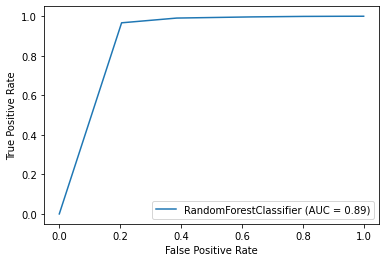

------------------------------- Features selected = 100 -------------------------------
Shape of X train is : (169550, 100)
Shape of X test is : (56517, 100)


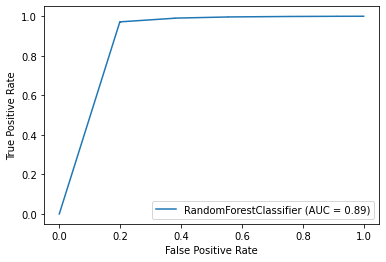

------------------------------- Features selected = 30 -------------------------------
Shape of X train is : (169550, 30)
Shape of X test is : (56517, 30)


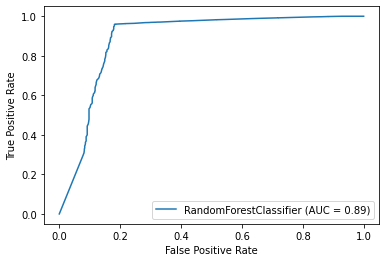

------------------------------- Features selected = 10 -------------------------------
Shape of X train is : (169550, 10)
Shape of X test is : (56517, 10)


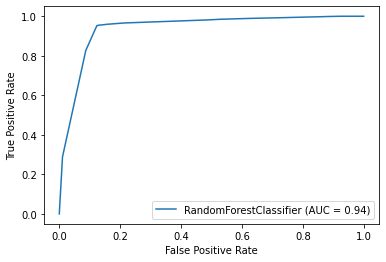

In [11]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(rfc, X_test_scld, y_test)
print('------------------------------- Features selected = ALL-------------------------------')
plt.show()

chi_rfc100, chi_rfc_pred, myX, fi=myrept(100)
disp = plot_roc_curve(chi_rfc100, myX, y_test)
plt.show()

chi_rfc30, chi_rfc_pred, myX, fi = myrept(30)
disp = plot_roc_curve(chi_rfc30, myX, y_test)
plt.show()

chi_rfc10, chi_rfc_pred, myX, fi=myrept(10)
disp = plot_roc_curve(chi_rfc10, myX, y_test)
plt.show()

**Part 5: (8 pts)** Plot the feature importance for each of the 4 random forest models that you have trained to show the top 5 features. ([Get feature names after feature selection](https://stackoverflow.com/a/43765224), [Plot feature importance using Pandas and matplotlib](https://stackoverflow.com/a/51520906))  

------------------------------- Features selected = 100 -------------------------------
Shape of X train is : (169550, 100)
Shape of X test is : (56517, 100)
------------------------------- Features selected = 30 -------------------------------
Shape of X train is : (169550, 30)
Shape of X test is : (56517, 30)
------------------------------- Features selected = 10 -------------------------------
Shape of X train is : (169550, 10)
Shape of X test is : (56517, 10)


<AxesSubplot:title={'center':'10 FEATURES importance plot top 5'}, xlabel='Relative Feature Importance'>

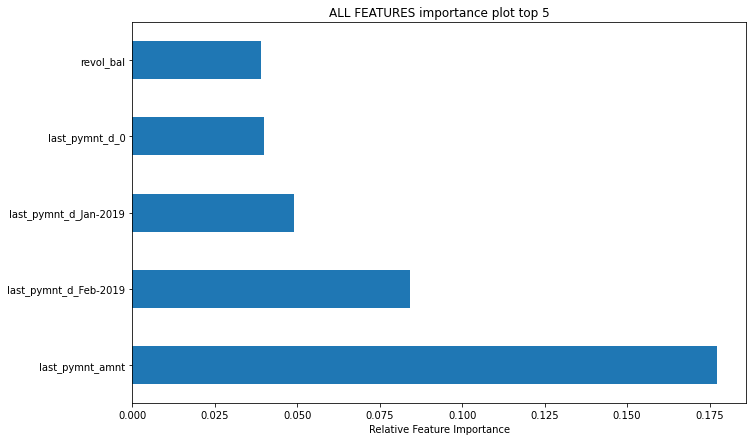

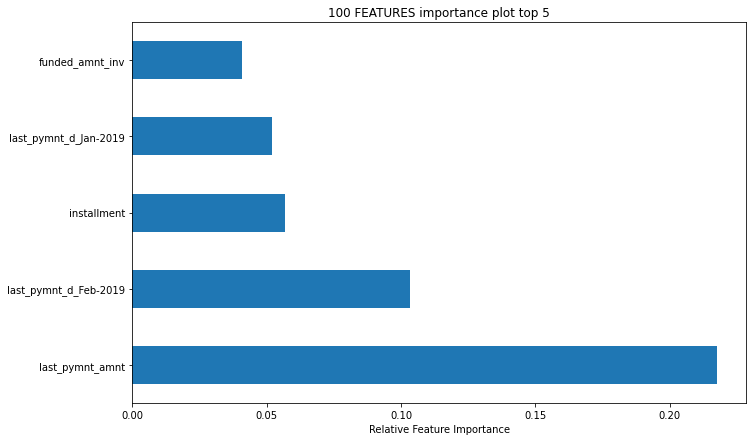

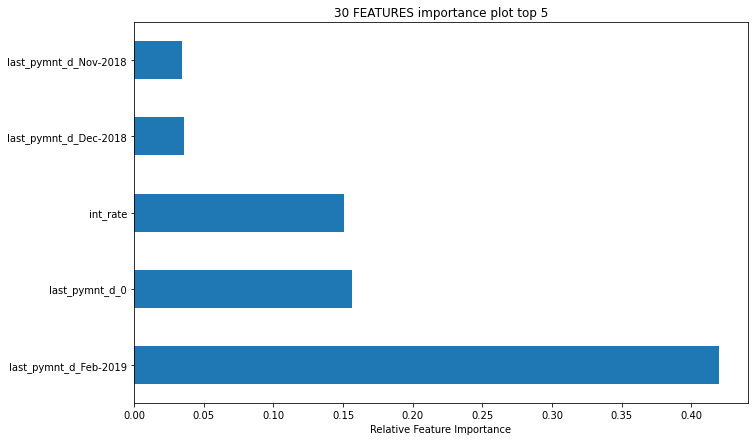

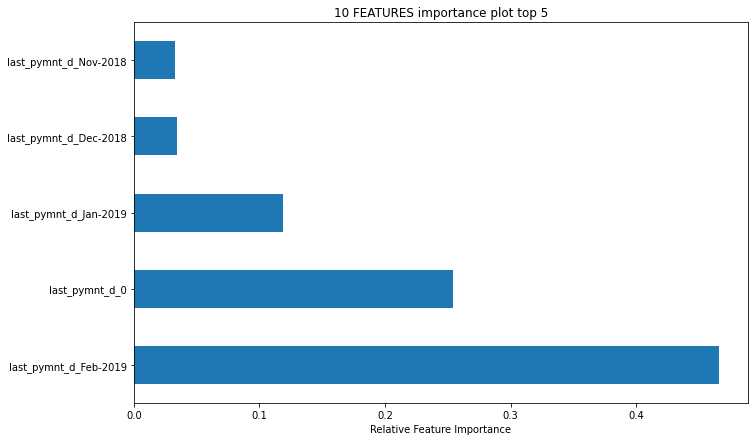

In [12]:
#print(list(dataframe.columns.values))
feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
#print('*** FEATURE IMPORTANCE ***')
plt.figure(figsize=(11,7))
plt.title('ALL FEATURES importance plot top 5')
plt.xlabel('Relative Feature Importance')
feat_importances.nlargest(5).plot(kind='barh')    
feat_importances.shape

chi_rfc100, chi_rfc_pred, myX, fi=myrept(100)
#print('*** FEATURE IMPORTANCE ***')
plt.figure(figsize=(11,7))
plt.title('100 FEATURES importance plot top 5')
plt.xlabel('Relative Feature Importance')
fi.nlargest(5).plot(kind='barh')

chi_rfc30, chi_rfc_pred, myX, fi=myrept(30)
#print('*** FEATURE IMPORTANCE ***')
plt.figure(figsize=(11,7))
plt.title('30 FEATURES importance plot top 5')
plt.xlabel('Relative Feature Importance')
fi.nlargest(5).plot(kind='barh')

chi_rfc10, chi_rfc_pred, myX, fi=myrept(10)
#print('*** FEATURE IMPORTANCE ***')
plt.figure(figsize=(11,7))
plt.title('10 FEATURES importance plot top 5')
plt.xlabel('Relative Feature Importance')
fi.nlargest(5).plot(kind='barh')

**Part 6: (2 pts)** What do you observe from the ROC curves?

We see that the AUC doesn't change much for different set of feature sets we use when use the RF classification. However, we do see that AUC is high for the select 10 features using chi2 rather than using all set or 100 or 30 features.

# Question 3 : Logistic Regression with Regularization and Decision Tree (25 pts)

The goal of this problem is to explore the effect of regularization on logistic regression for binary classification, we will be using the diabetes dataset. 
This dataset is used to predict if a person is having 
diabetes based on feature variables including blood pressure, bmi, age etc. The target variable is stored in "outcome" column.

* Load the "diabetes.csv" and partition it into features (X) and the target label (y) for classification task. Then, use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split data into training and testing: test_size=0.33, random_state=42. 


* We need to use [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Instead of fitting a model on the original data, we use StandardScaler to center each feature. Also remember that when we have training and testing data, we fit preprocessing parameters on training data and apply them to all testing data. You should scale only the features (independent variables), not the target variable y. 

   Note: X should have 8 features.


**Part 1: (6 pts)** Fit a [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model with penalty $l2$
(Ridge Regularization) for the following values of regularization  C = $[0.0001,0.001,0.1,10,100]$ using the training data. Report the accuracy score on the test data averaged over 5 runs of the model for each of the C values. 

  Note : Smaller values of C indicate stronger regularization

    

**Part 2: (6 pts)** Fit a [Decision tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) classifier on the training data, and report the accuracy score on the test data averaged over 5 runs. Briefly explain which of the models performed the best Logistic Regression + regularization or Decision Tree Classifier and why. 


* Now, We will check if the decision boundary from logistic regression is linear by using a 2D plot.


**Part 3: (4 pts)** Select the top two most important features ([Feature importance](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_)) using the training data with a Decision Tree Classifier and random_state = 10. Subset the train and test data to have only the selected features. This will be used as the training and test data for part $4$.


**Part 4: (8 pts)** Fit a [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model with penalty = $l2$, C = 10 (Ridge Regularization) and random state = 0 for the training data from part $3$ . Plot the decision boundary of the logistic regression model with the two features, as X and Y axis. Here is an [example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html) . Plot the scatter points for the test data, on the same graph showing the two classes as two different color. 

  * Hint : You can use the below limits for plotting the decision boundary, where $X[:,0]$ indicates feature 1 values and $X[:,1]$ indicates feature 2 values of the train dataset. 

     $ x_\min, x_\max = X[:, 0].min() - .5, X[:, 0].max() + .5 $ 

     $ y_\min, y_\max = X[:, 1].min() - .5, X[:, 1].max() + .5 $
   

# Solution

#### Loading dataset and pre-processing (**1 pt**)

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('diabetes.csv')
#print(df.head())
y=df['Outcome'] 
X=df.drop('Outcome',1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=42)


# Min-Max scaling
scaler = StandardScaler()
X_train_scld=scaler.fit_transform(X_train)#Fit transform min-max scaler to train data
X_test_scld=scaler.transform(X_test) # transform test data based on train data fit by min max scaler

#### Part 1 (**6 pts**)

In [14]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#for c in [0.0001,0.001,0.1,10,100]:
#    for i in range(5):
#        clf = LogisticRegression(penalty='l2',C=c,max_iter=10000).fit(X_train, y_train)
#        accuracy=clf.score(X_test_scld,y_test)
#        print("Iteration ",i)
#        print("accuraracy with C ",c)
#        print(accuracy)
accuracies=[]      
for c in [0.0001,0.001,0.1,10,100]:
    accuracy=[]
    scores=[]
    for i in range(5):
        clf = LogisticRegression(penalty='l2',C=c).fit(X_train_scld, y_train)
        #scores.append(accuracy_score(y_test,clf.predict(X_test_scld)))
        accuracy.append(clf.score(X_test_scld,y_test))
        #print(clf.score(X_test_scld,y_test))
    print("accuracy with C ",c) 
    print(np.mean(accuracy))
    accuracies.append(np.mean(accuracy))
print("mean accuracy")
print(np.mean(accuracies))
    #print(np.mean(scores))

accuracy with C  0.0001
0.6614173228346457
accuracy with C  0.001
0.6614173228346457
accuracy with C  0.1
0.7440944881889764
accuracy with C  10
0.7480314960629921
accuracy with C  100
0.7480314960629921
mean accuracy
0.7125984251968503


#### Part 2 (**6 pts**)

In [15]:
from sklearn.tree import DecisionTreeClassifier

accuracy=[]
scores=[]
for i in range(5):
    dtree = DecisionTreeClassifier()
    dtree.fit(X_train_scld, y_train)
    predictions=dtree.predict(X_test_scld)
    accuracy.append(clf.score(X_test_scld,y_test))
print("Decision tree accuracy") 
print(np.mean(accuracy))
    #print(np.mean(scores))

Decision tree accuracy
0.7480314960629921


The average accuracy for logistic regression models with different regularizATION values is about 0.712 while, the decision tree accuracy is 0.748. Decision tree does better if we compare the average of logistic regression with decision tree but if we compare the best logistic regression model then they're about the same. Decision tree is better because at every iteration it creating different splits and thus generalizes better since doing things this way increases the ambiguity in the MSE calculation and can lead to lower error. This is the advantage of ensemble methods in general

#### Part 3 (**4 pts**)

In [16]:
dtree = DecisionTreeClassifier(random_state=10)
dtree.fit(X_train, y_train)
print(dtree.feature_importances_)
idx = np.argpartition(dtree.feature_importances_, -2)[-2:]
#print("top two features are")
print(np.argpartition(dtree.feature_importances_, -2)[-2:])
print("top two features are")
print(X.columns[idx])
X_train_scld_filtered=X_train_scld[:,idx]
X_train_scld_filtered.shape
X_test_scld_filtered=X_test_scld[:,idx]
X_test_scld_filtered.shape

[0.06204322 0.40446797 0.10523598 0.04853007 0.08183749 0.14079905
 0.07235549 0.08473073]
[5 1]
top two features are
Index(['BMI', 'Glucose'], dtype='object')


(254, 2)

#### Part 4 (**8 pts**)

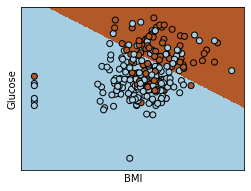

In [17]:
import matplotlib.pyplot as plt
clf = LogisticRegression(random_state=0,penalty='l2',C=10).fit(X_train_scld_filtered, y_train)

X = X_test_scld_filtered
Y = y_test

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('BMI')
plt.ylabel('Glucose')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

# Question 4 - Comparison of different ensembles method for classification (25 pts)

In this question, we will compare performance of different ensemble methods for classification problems: [Bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html), [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), [GradientBoosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), and [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) Classifiers.

[Spam Classification Data](https://archive.ics.uci.edu/ml/datasets/Spambase) of UCI will be used (you can use the data provided: 'spam_uci.csv'). Don't worry about column names. The last column represents target label, 1 if spam and zero otherwise.

* Load the data and partition it into features (X) and the target label (y) for classification task. Then, use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split data into training and testing: test_size=0.33, random_state=42. 



**Part 1: (4 pts)** Use a Decision Tree Classifier with random_state = 10 and Logistic Regression with random_state = 10 and solver ="lbfgs" for the spam classification problem. Report the accuracy_score and roc_auc_score on the test data for each classifier.


**Part 2: (8 pts)** Create an ensemble of 50 classifiers (i.e n_estimators = 50) with random_state = 10 for [bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) with base classifier as Decision Tree Classifier and Logistic Regression from part $1$ . Report accuracy_score and roc_auc_score on the test data for both the Bagging classifiers. Compare the results and breifly explain the effect of using bagging for the spam classification problem for both the Logistic Regression and Decision Tree base classifier.


* Now we will look at the effect of other ensemble methods on this problem.


**Part 3: (5 pts)** Use a [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to classify whether an email is spam. Report your testing accuracy ([accuracy_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)) and [roc_auc_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score). You will need [predict_proba](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba) for roc_auc_score. 


**Part 4: (5 pts)** Use [Gradient Boosting Decision Tree](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) (GBDT), and [AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) for the spam classification problem.  Report  accuracy_score and roc_auc_score on the test data for each algorithm. 

  Note : For part 3 and 4 find the best values for the hyper parameters of each of the models by using GridSearchCV. 


**Part 5: (3 pts)** Briefly explain which of the three ensemble method above from Part 3&4 performed the best and why?


# Solution

#### Loading and pre-processing dataset

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

df = pd.read_csv('spam_uci.csv',index_col=0)
#df.head()
#print(df.head())
y=df['57'] 
X=df.drop('57',1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=42)


# Min-Max scaling
#scaler = StandardScaler()
#X_train_scld=scaler.fit_transform(X_train)#Fit transform min-max scaler to train data
#X_test_scld=scaler.transform(X_test) # transform test data based on train data fit by min max scaler

#### Part 1 (**4 pts**)

Accuracy for Decision Tree  0.9117840684660962
ROC AUC Score for Decision Tree  0.9085903594264297


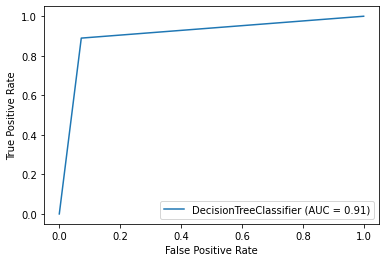

In [19]:
dtree = DecisionTreeClassifier(random_state=10)
dtree.fit(X_train, y_train)

from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score

print("Accuracy for Decision Tree ",accuracy_score(y_test,dtree.predict(X_test)))
print("ROC AUC Score for Decision Tree ",roc_auc_score(y_test,dtree.predict_proba(X_test)[:, 1]))
roc = plot_roc_curve(dtree, X_test, y_test)



Accuracy for Logistic Regression  0.923633969716919
ROC AUC Score for Logistic Regression  0.9661328226689346


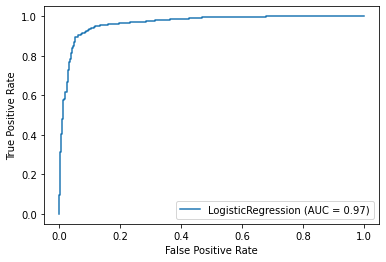

In [20]:
clf = LogisticRegression(random_state=10,solver ="lbfgs").fit(X_train, y_train)
print("Accuracy for Logistic Regression ",accuracy_score(y_test,clf.predict(X_test)))
print("ROC AUC Score for Logistic Regression ",roc_auc_score(y_test,clf.predict_proba(X_test)[:, 1]))
roc = plot_roc_curve(clf, X_test, y_test)

#### Part 2 (**8 pts**)

Accuracy for Decision Tree  0.9447004608294931
ROC AUC Score for Ensemble DT  0.9813261583558889


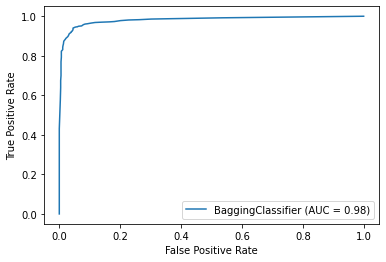

In [21]:
from sklearn.ensemble import BaggingClassifier

dtree = BaggingClassifier(base_estimator=DecisionTreeClassifier()\
                          ,n_estimators=50, random_state=10).fit(X_train, y_train)
print("Accuracy for Decision Tree ",accuracy_score(y_test,dtree.predict(X_test)))
print("ROC AUC Score for Ensemble DT ",roc_auc_score(y_test,dtree.predict_proba(X_test)[:, 1]))
roc = plot_roc_curve(dtree, X_test, y_test)


Accuracy for Logistic Regression  0.9269256089532587
ROC AUC Score for Ensemble Logistic Regression  0.9696686030547145


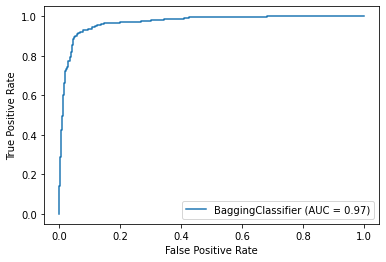

In [22]:
clf = BaggingClassifier(base_estimator=LogisticRegression(random_state=10,solver ="lbfgs")\
                        ,n_estimators=50, random_state=10).fit(X_train, y_train)
print("Accuracy for Logistic Regression ",accuracy_score(y_test,clf.predict(X_test)))
print("ROC AUC Score for Ensemble Logistic Regression ",roc_auc_score(y_test,clf.predict_proba(X_test)[:, 1]))
roc = plot_roc_curve(clf, X_test, y_test)

The average MSE of an ensemble method is composed of the average MSE and the ambiguity, where ambiguity is the variance in the models. Logistic Regression seems to find the same model always, so it doesnt benefit from ensemble methods as much as decision tree.

#### Part 3 (**5 pts**)

Accuracy for RandomForest  0.9578670177748518
(1519, 2)
ROC AUC Score for RandomForest  0.98668064574797


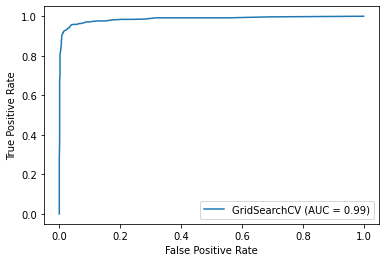

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
#clf = RandomForestClassifier(random_state=10).fit(X_train, y_train)
parameters = {'n_estimators':(10, 40,50), 'criterion':('gini','entropy')}
clf = GridSearchCV(RandomForestClassifier(random_state=10), parameters).fit(X_train,y_train)
print("Accuracy for RandomForest ",accuracy_score(y_test,clf.predict(X_test)))
#print(y_test.shape)
print(clf.predict_proba(X_test).shape)
print("ROC AUC Score for RandomForest ",roc_auc_score(y_test,clf.predict_proba(X_test)[:, 1]))
roc = plot_roc_curve(clf, X_test, y_test)

#### Part 4 (**5 pts**)

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
#clf = GradientBoostingClassifier(random_state=10).fit(X_train, y_train)
parameters = {'learning_rate':(.01, 0.1,1), 'n_estimators':(10, 40,50)}
clf = GridSearchCV(GradientBoostingClassifier(random_state=10), parameters).fit(X_train,y_train)
print("Accuracy for GradientBoostingClassifier ",accuracy_score(y_test,clf.predict(X_test)))
print(y_test.shape)
print(clf.predict_proba(X_test).shape)
print("ROC AUC Score for GradientBoostingClassifier ",roc_auc_score(y_test,clf.predict_proba(X_test)[:, 1]))

Accuracy for GradientBoostingClassifier  0.9440421329822252
(1519,)
(1519, 2)
ROC AUC Score for GradientBoostingClassifier  0.9841433711695712


In [25]:
from sklearn.ensemble import AdaBoostClassifier

#clf = AdaBoostClassifier(random_state=10).fit(X_train, y_train)
parameters = {'learning_rate':(.01, 0.1,1), 'n_estimators':(10, 40,50)}
clf = GridSearchCV(AdaBoostClassifier(random_state=10), parameters).fit(X_train,y_train)
print("Accuracy for AdaBoostClassifier ",accuracy_score(y_test,clf.predict(X_test)))
print(y_test.shape)
print(clf.predict_proba(X_test).shape)
print("ROC AUC Score for AdaBoostClassifier ",roc_auc_score(y_test,clf.predict(X_test)))

Accuracy for AdaBoostClassifier  0.9381171823568137
(1519,)
(1519, 2)
ROC AUC Score for AdaBoostClassifier  0.9354492741219388


#### Part 5 (**3 pts**)

The best model was RandomForest, followed by GradientBoost and AdaBoost. Random forest build model from various small but fully grown decision trees and at the same time uses different combination of features to build these trees, so it accounts for a high variance between the trees and low bias and thus ends up as a model. Since RandomForest is a high variance and low bias model it reduces error by reducing the variance. Our dataset is highly imbalanced.
